Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Split sizes -> Train: 3326, Val: 713, Test: 713
Dataset mean: [0.59929072 0.61981954 0.63140094] std: [0.163136   0.16411659 0.18730553]
Saved filepaths.npy, labels_encoded.npy, split_*.npy, class_names.npy, mean_std.npy


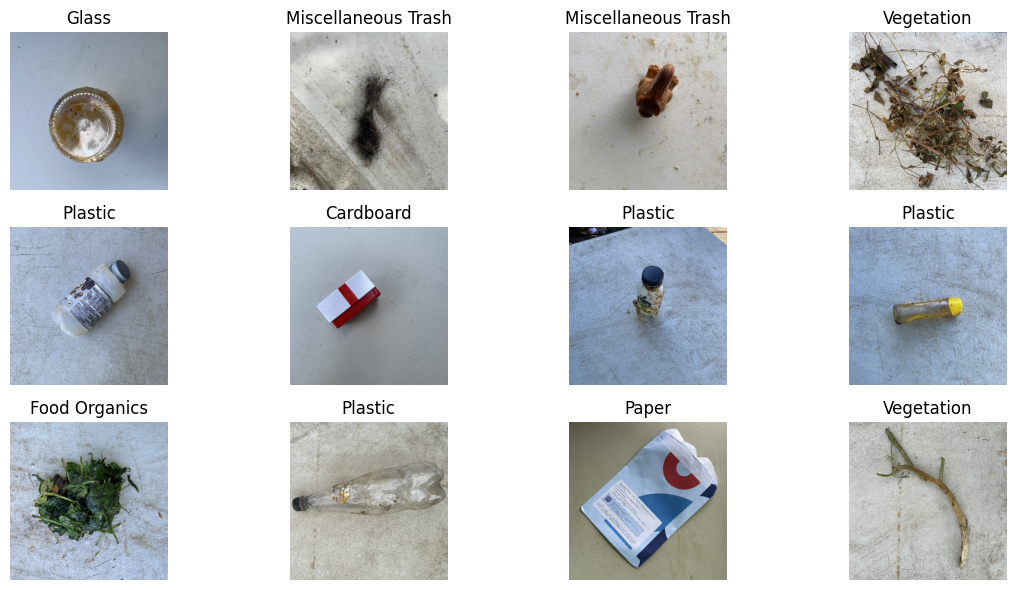

In [4]:
# --- Notebook: 02_Splits_MeanStd_AugPreview.ipynb ---

import json
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 1) Load cleaned manifest
df = pd.read_csv("manifest_clean.csv")
with open("classes.json") as f:
    class_names = json.load(f)
print("Classes:", class_names)

# 2) Encode labels
le = LabelEncoder()
le.fit(class_names)  # keep class order stable
y = le.transform(df["label"].values)
paths = df["path"].values

# 3) Build exact 70/15/15 stratified split
idx_all = np.arange(len(df))
trainval_idx, test_idx = train_test_split(
    idx_all, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)
val_fraction = 0.15 / 0.85  # ≈ 0.17647
train_idx, val_idx = train_test_split(
    trainval_idx, test_size=val_fraction, random_state=RANDOM_SEED, stratify=y[trainval_idx]
)

print(f"Split sizes -> Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# 4) Compute dataset mean/std over a sample (for Normalize)
def compute_mean_std(sel_paths, sample=3000, resize=224):
    sel = np.random.choice(sel_paths, size=min(sample, len(sel_paths)), replace=False)
    ch_sum = np.zeros(3); ch_sq = np.zeros(3); n = 0
    for p in sel:
        x = np.asarray(Image.open(p).convert("RGB").resize((resize,resize)), dtype=np.float32)/255.0
        ch_sum += x.reshape(-1,3).mean(axis=0)
        ch_sq  += (x.reshape(-1,3)**2).mean(axis=0)
        n += 1
    mean = ch_sum/n
    std  = np.sqrt(ch_sq/n - mean**2)
    return mean, std

mean, std = compute_mean_std(paths[train_idx], sample=3000, resize=224)
print("Dataset mean:", mean, "std:", std)

np.save("class_names.npy", np.array(class_names))
np.save("filepaths.npy", paths)
np.save("labels_encoded.npy", y)
np.save("split_train.npy", train_idx)
np.save("split_val.npy", val_idx)
np.save("split_test.npy", test_idx)
np.save("mean_std.npy", np.stack([mean, std], axis=0))

print("Saved filepaths.npy, labels_encoded.npy, split_*.npy, class_names.npy, mean_std.npy")

# 5) Quick augmentation preview (sanity)
train_tf = T.Compose([
    T.ToTensor(),  # expects PIL -> tensor in [0,1]
])

def show_examples(idx_list, n=12):
    sel = np.random.choice(idx_list, size=min(n, len(idx_list)), replace=False)
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(sel):
        img = Image.open(paths[idx]).convert("RGB")
        plt.subplot(3,4,i+1); plt.imshow(img); plt.axis("off"); plt.title(df.iloc[idx]["label"])
    plt.tight_layout(); plt.show()

show_examples(train_idx, n=12)
